In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import time

In [2]:
# Define dataset paths
train_dir = "/kaggle/input/retinal-fundus-aug/train"
val_dir = "/kaggle/input/retinal-fundus-aug/val"
test_dir = "/kaggle/input/retinal-fundus-aug/test"

# Image data preprocessing
img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
val_generator = val_datagen.flow_from_directory(val_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)
test_generator = test_datagen.flow_from_directory(test_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)

# Load pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

# Custom classification head
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(len(train_generator.class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

Found 1917 images belonging to 7 classes.
Found 581 images belonging to 7 classes.
Found 586 images belonging to 7 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
# Train model
start_time = time.time()
history = model.fit(train_generator, validation_data=val_generator, epochs=10)
training_time = time.time() - start_time

# Evaluate Model
y_true = val_generator.classes
y_pred = np.argmax(model.predict(val_generator), axis=1)
class_labels = list(train_generator.class_indices.keys())

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


60/60 ━━━━━━━━━━━━━━━━━━━━ 180s 3s/step - accuracy: 0.2753 - loss: 1.9392 - val_accuracy: 0.4441 - val_loss: 1.4708
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.4536 - loss: 1.4473 - val_accuracy: 0.5215 - val_loss: 1.2974
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.4657 - loss: 1.4037 - val_accuracy: 0.5250 - val_loss: 1.2622
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.4694 - loss: 1.3637 - val_accuracy: 0.5714 - val_loss: 1.1629
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.5437 - loss: 1.2202 - val_accuracy: 0.5542 - val_loss: 1.1595
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.5668 - loss: 1.1679 - val_accuracy: 0.5938 - val_loss: 1.0957
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.5533 - loss: 1.2046 - val_accuracy: 0.6213 - val_loss: 1.0578
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.5925 - loss: 1.1015 - val_accuracy: 0.6627 - val_loss: 1.0007
Ep

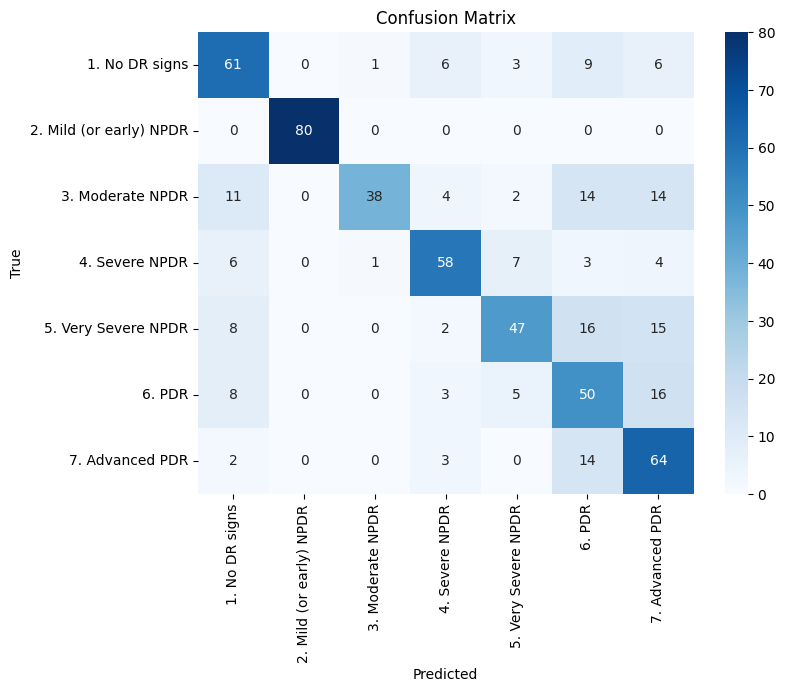

Training Time: 936.38 seconds
Accuracy: 0.6850
Precision: 0.7275
Recall (Sensitivity): 0.6880
F1-Score: 0.6887
Specificity: 0.9234


In [4]:

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Compute Metrics
TN = np.diag(cm).sum() - cm.sum(axis=0)
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)

precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)
specificity = TN / (TN + FP)
accuracy = np.trace(cm) / np.sum(cm)

print(f"Training Time: {training_time:.2f} seconds")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {np.mean(precision):.4f}")
print(f"Recall (Sensitivity): {np.mean(recall):.4f}")
print(f"F1-Score: {np.mean(f1_score):.4f}")
print(f"Specificity: {np.mean(specificity):.4f}")